In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

# Task 1

Depth with lowest median difference : 21


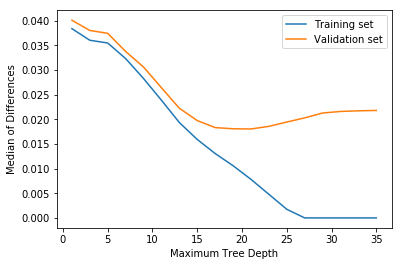

In [2]:
def get_features_targets(data):
    features = np.zeros((data.shape[0], 4))
    features[:, 0] = data['u'] - data['g']
    features[:, 1] = data['g'] - data['r']
    features[:, 2] = data['r'] - data['i']
    features[:, 3] = data['i'] - data['z']
    
    return features, data['redshift']


def median_diff(predicted, actual):
    return np.median(np.abs(predicted - actual))


def accuracy_by_treedepth(features, targets, depths):
    # split the data into testing and training sets
    split_index = int(0.5 * len(features))
    train_features = features[:split_index]
    test_features = features[split_index:]
    
    train_targets = targets[:split_index]
    test_targets = targets[split_index:]

    # initialise arrays or lists to store the accuracies for the below loop
    train_accuracy = []
    test_accuracy = []

    # loop through depths
    for depth in depths:
        # initialize model with the maximum depth. 
        dtr = DecisionTreeRegressor(max_depth=depth)
    
        # train the model using the training set
        dtr.fit(train_features, train_targets)
    
        # get predictions for the training set and calculate their median_diff
        train_predictions = dtr.predict(train_features)
        train_median_diff = median_diff(train_targets, train_predictions)
        train_accuracy.append(train_median_diff)
    
        # get predictions for the testing set and calculate their median_diff
        test_predictions = dtr.predict(test_features)
        test_median_diff = median_diff(test_targets, test_predictions)
        test_accuracy.append(test_median_diff)
        
    # return the accuracies for the training and testing sets
    return train_accuracy, test_accuracy


def main():
    data = np.load('data1/sdss_galaxy_colors.npy')
    features, targets = get_features_targets(data)

    # Generate several depths to test
    tree_depths = [i for i in range(1, 36, 2)]

    # Call the function
    train_med_diffs, test_med_diffs = accuracy_by_treedepth(features, targets, tree_depths)
    print("Depth with lowest median difference : {}".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))

    # Plot the results
    train_plot = plt.plot(tree_depths, train_med_diffs, label='Training set')
    test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation set')
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Median of Differences")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()

# Task 2

In [3]:
def cross_validate_model(model, features, targets, k):
    kf = KFold(n_splits=k, shuffle=True)

    # initialise a list to collect median_diffs for each iteration of the loop
    # below
    accuracy = []

    for train_indices, test_indices in kf.split(features):
        train_features = features[train_indices]
        test_features = features[test_indices]
        train_targets = targets[train_indices]
        test_targets = targets[test_indices]
        
        # fit the model for the current set
        model.fit(train_features, train_targets)
        
        # predict using the model
        prediction = model.predict(test_features)
     
        # calculate the median_diff from predicted values and append to
        # results array
        accuracy.append(median_diff(prediction, test_targets))
 
    # return the list with your median difference values
    return accuracy


def main():
    data = np.load('data1/sdss_galaxy_colors.npy')
    features, targets = get_features_targets(data)

    # initialize model with a maximum depth of 19
    dtr = DecisionTreeRegressor(max_depth=19)

    # call your cross validation function
    diffs = cross_validate_model(dtr, features, targets, 10)

    # Print the values
    print('Differences: {}'.format(', '.join(['{:.3f}'.format(val) for val in diffs])))
    print('Mean difference: {:.3f}'.format(np.mean(diffs)))


if __name__ == '__main__':
    main()

Differences: 0.017, 0.017, 0.017, 0.017, 0.018, 0.017, 0.018, 0.017, 0.017, 0.017
Mean difference: 0.017


# Task 3

KFold cross validation of predictions

Median difference: 0.017


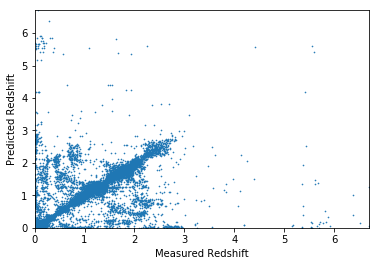

In [4]:
def cross_validate_predictions(model, features, targets, k):
    kf = KFold(n_splits=k, shuffle=True)

    # declare an array for predicted redshifts from each iteration
    all_predictions = np.zeros_like(targets)

    for train_indices, test_indices in kf.split(features):
        # split the data into training and testing
        train_features = features[train_indices]
        test_features = features[test_indices]
        train_targets = targets[train_indices]
    
        # fit the model for the current set
        model.fit(train_features, train_targets)
        
        # predict using the model
        predictions = model.predict(test_features)
        
        # put the predicted values in the all_predictions array defined above
        all_predictions[test_indices] = predictions

    # return the predictions
    return all_predictions    


def main():
    data = np.load('data1/sdss_galaxy_colors.npy')
    features, targets = get_features_targets(data)

    # initialize model
    dtr = DecisionTreeRegressor(max_depth=19)

    # call your cross validation function
    predictions = cross_validate_predictions(dtr, features, targets, 10)

    # calculate and print the rmsd as a sanity check
    diffs = median_diff(predictions, targets)
    print('Median difference: {:.3f}'.format(diffs))

    # plot the results to see how well our model looks
    plt.scatter(targets, predictions, s=0.4)
    plt.xlim((0, targets.max()))
    plt.ylim((0, predictions.max()))
    plt.xlabel('Measured Redshift')
    plt.ylabel('Predicted Redshift')
    plt.show()


if __name__ == "__main__":
    main()

# Task 4

In [6]:
def split_galaxies_qsos(data):
    # split the data into galaxies and qsos arrays
    galaxies = data[data['spec_class'] == b'GALAXY']
    qsos = data[data['spec_class'] == b'QSO']

    # return the separated galaxies and qsos arrays
    return galaxies, qsos


def cross_validate_median_diff(data):
    features, targets = get_features_targets(data)
    dtr = DecisionTreeRegressor(max_depth=19)
    return np.mean(cross_validate_model(dtr, features, targets, 10))


def main():
    data = np.load('data1/sdss_galaxy_colors.npy')

    # Split the data set into galaxies and QSOs
    galaxies, qsos = split_galaxies_qsos(data)

    # Cross validate the model and get the cross-validated median difference
    # The cross_validated_med_diff function is in "written_functions"
    galaxy_med_diff = cross_validate_median_diff(galaxies)
    qso_med_diff = cross_validate_median_diff(qsos)

    # Print the results
    print("Median difference for Galaxies: {:.3f}".format(galaxy_med_diff))
    print("Median difference for QSOs: {:.3f}".format(qso_med_diff))


if __name__ == "__main__":
    main()

Median difference for Galaxies: 0.016
Median difference for QSOs: 0.073
